In [1]:
# This notebook will run various models on the data to predict a more accurate value of the home.
# Feature engineering techniques will be employed.
# Many models will be built and compared to find the best model for the job.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from xgboost import XGBRegressor
from scipy.stats import ks_2samp

pd.options.display.max_columns = None

In [3]:
# https://zacstewart.com/2014/08/05/pipelines-of-featureunions-of-pipelines.html
# https://stackoverflow.com/questions/24458645/label-encoding-across-multiple-columns-in-scikit-learn

class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    # def fit(self,X,y=None):
    #     return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        # return self.fit(X,y).transform(X)
        return self.transform(X)


def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


# Find best random state that minimizes the K-S distance:
# Use that min value for random state in the "actual" split below.
def minKS_tts(X, y, test_size):
    n_features = X.shape[1]
    n_tries = 100
    result = []
    for random_state in range(n_tries):
        X_train, X_test, _, _ = train_test_split(X, y, test_size=test_size, random_state=random_state)
        distances = list(map(lambda i : ks_2samp(X_train[:,i],X_test[:,i]).statistic,range(n_features)))
        result.append((random_state,max(distances)))
    result.sort(key = lambda x : x[1])
    return result[0][0]

# Matches 'series' column data statistical distribution to 'reference' column's statistical distribution.
# Uses ECDF
def match_ecdf(series, reference):
    sorted_series = np.sort(series, kind='mergesort')
    sorted_reference = np.sort(reference, kind='mergesort')
    ecdf_series = np.linspace(0, 1, len(series), endpoint=False)
    ecdf_reference = np.linspace(0, 1, len(reference), endpoint=False)
    matched_values = np.interp(ecdf_series, ecdf_reference, sorted_reference)
    matched_series = np.interp(sorted_series, sorted_series, matched_values)
    return matched_series

In [4]:
'''
Read in csv files.
'''
df_forSale = pd.read_csv('cleaned_forSale_data.csv', index_col=0)
df_recentlySold = pd.read_csv('cleaned_recentlySold_data.csv', index_col=0)

df_recentlySold['dateSold'] = pd.to_datetime(df_recentlySold['dateSoldString'])
df_recentlySold.drop('dateSoldString', axis=1, inplace=True)

modelColumns_recentlySold = ['daysOnZillow','zipcode','longitude','yearBuilt','bedrooms','bathrooms','livingAreaValue',
                             'resoFacts.associationFee','priceOutlier']

modelColumns_forSale = ['daysOnZillow','zipcode','longitude','yearBuilt','bedrooms','bathrooms','livingAreaValue',
                        'zestimate','resoFacts.associationFee','priceOutlier']

addtl = ['resoFacts.isSeniorCommunity','cityId','restimateHighPercent','restimateLowPercent','mortgageRates.thirtyYearFixedRate','mortgageRates.fifteenYearFixedRate',
         'resoFacts.garageSpaces','resoFacts.hasAdditionalParcels','resoFacts.hasAssociation',
         'resoFacts.hasGarage','resoFacts.hasPrivatePool','resoFacts.hasSpa','resoFacts.hasView','resoFacts.hasWaterfrontView',
         'resoFacts.taxAnnualAmount','schoolMaxRating','schoolMinDistance']

booleanFeatures = ['resoFacts.isSeniorCommunity','resoFacts.isSeniorCommunity','resoFacts.hasAdditionalParcels','resoFacts.hasAssociation',
                   'resoFacts.hasGarage','resoFacts.hasPrivatePool','resoFacts.hasSpa','resoFacts.hasView','resoFacts.hasWaterfrontView']

# rejectedFeatures = ['resoFacts.hasWaterfrontYN','rentZestimate','mortgageRates.arm5Rate','resoFacts.garageSpaces','listingSubType.isForeclosure','favoriteCount'resoFacts.hasAttachedProperty','lotAreaValue','taxAssessedValue','resoFacts.hasAttachedGarage']

modelColumns_recentlySold = modelColumns_recentlySold + addtl + ['price']
modelColumns_forSale = modelColumns_forSale + addtl

One of the most asked questions in data science/ML: Do you apply feature scaling before or after splitting your data?

Answer: Only one answer. ALWAYS AFTER SPLITTING DATA!! --  You need the test set to be a completely new, unseen data set. Feature scaling calculates means/std.dev's and so it must be done after the split to keep the two sets seperate. Key term: Information Leakage.

In [5]:
'''
Prep data for model training
'''
# Select only the columns needed for training/testing, apply OneHotEncoding, and convert to Numpy array for training.
modelData_recentlySold = df_recentlySold[modelColumns_recentlySold]
modelData_recentlySold = modelData_recentlySold.loc[modelData_recentlySold['priceOutlier']==0]
modelData_recentlySold.drop('priceOutlier', axis=1, inplace=True)
X_recentlySold = modelData_recentlySold.columns.difference(['price'], sort=False)
X_recentlySold = modelData_recentlySold[X_recentlySold]
X_recentlySold = np.array(MultiColumnLabelEncoder(columns=booleanFeatures)
                          .fit_transform(X_recentlySold))
y_recentlySold = np.array(modelData_recentlySold[['price']])
y_recentlySold = y_recentlySold.ravel()

modelData_forSale = df_forSale[modelColumns_forSale]
modelData_forSale = modelData_forSale.loc[modelData_forSale['priceOutlier']==0]
modelData_forSale.drop('priceOutlier', axis=1, inplace=True)
zestimate = np.array(modelData_forSale['zestimate'])
modelData_forSale.drop('zestimate', axis=1, inplace=True)
X_forSale = np.array(MultiColumnLabelEncoder(columns=booleanFeatures)
                     .fit_transform(modelData_forSale))

'''
Apply PCA??



'''


for i in range(X_forSale.shape[1]):
    '''??????Does this need to be applied to all columns or can I select which ones to match??????'''
    if i not in [1, 5, 8, 9, 15, 16, 17, 18, 19, 20, 21, 23, 24]:
        X_recentlySold[:,i] = match_ecdf(X_recentlySold[:,i], X_forSale[:,i])

# for i in range(X_forSale.shape[1]):
#     # Assuming 'data1' and 'data2' are your datasets
#     statistic, p_value = ks_2samp(X_forSale[:, i], X_recentlySold[:, i])
#     if p_value < 0.05:
#         print(f"Distributions are significantly different: {statistic, p_value}")
#     else:
#         print(f"Distributions are not significantly different. {statistic, p_value}")


# Split the data: recentlySold = 80% train/20% test. forSale = 100% test
X_train, X_test, y_train, y_test = train_test_split(X_recentlySold, y_recentlySold, test_size=0.2, random_state=minKS_tts(X_recentlySold, y_recentlySold, 0.2))

# Feature Scaling
scaler = RobustScaler()

# X_combined = np.concatenate([X_train])
# X_combined = scaler.fit_transform(X_combined) # data leakage if concat above has more than X_train!!!!
X_train = scaler.fit_transform(X_train)

# X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# X_forSale = scaler.transform(X_temp)
X_forSale = scaler.transform(X_forSale)

In [7]:
test_min = []
test_max = []
sale_min = []
sale_max = []
for idx in range(0,X_test.shape[1]):
    test_min.append(X_train[:,idx].min())
    test_max.append(X_train[:,idx].max())
    sale_min.append(X_forSale[:,idx].min())
    sale_max.append(X_forSale[:,idx].max())

checkDict = {'X_Test Min':test_min, 'X_forSale Min':sale_min, 'X_Test Max':test_max, 'X_forSale Max':sale_max}

df_check = pd.DataFrame(checkDict)
df_check.head(25)

,X_Test Min,X_forSale Min,X_Test Max,X_forSale Max
0,-0.471264,-0.471264,13.862069,13.862069
1,-5.090909,-5.090909,1.636364,1.636364
2,-2.796391,-2.796391,2.332442,2.332442
3,-2.325581,-2.325581,0.651163,0.651163
4,-3.217032,-4.000000,5.000000,5.000000
5,-2.000000,-1.000000,5.000000,6.000000
6,-2.065965,-2.065965,7.799212,7.799212
7,0.000000,0.000000,30.303030,30.303030
8,0.000000,0.000000,1.000000,1.000000
9,-0.295175,-0.295175,9.425436,9.425436


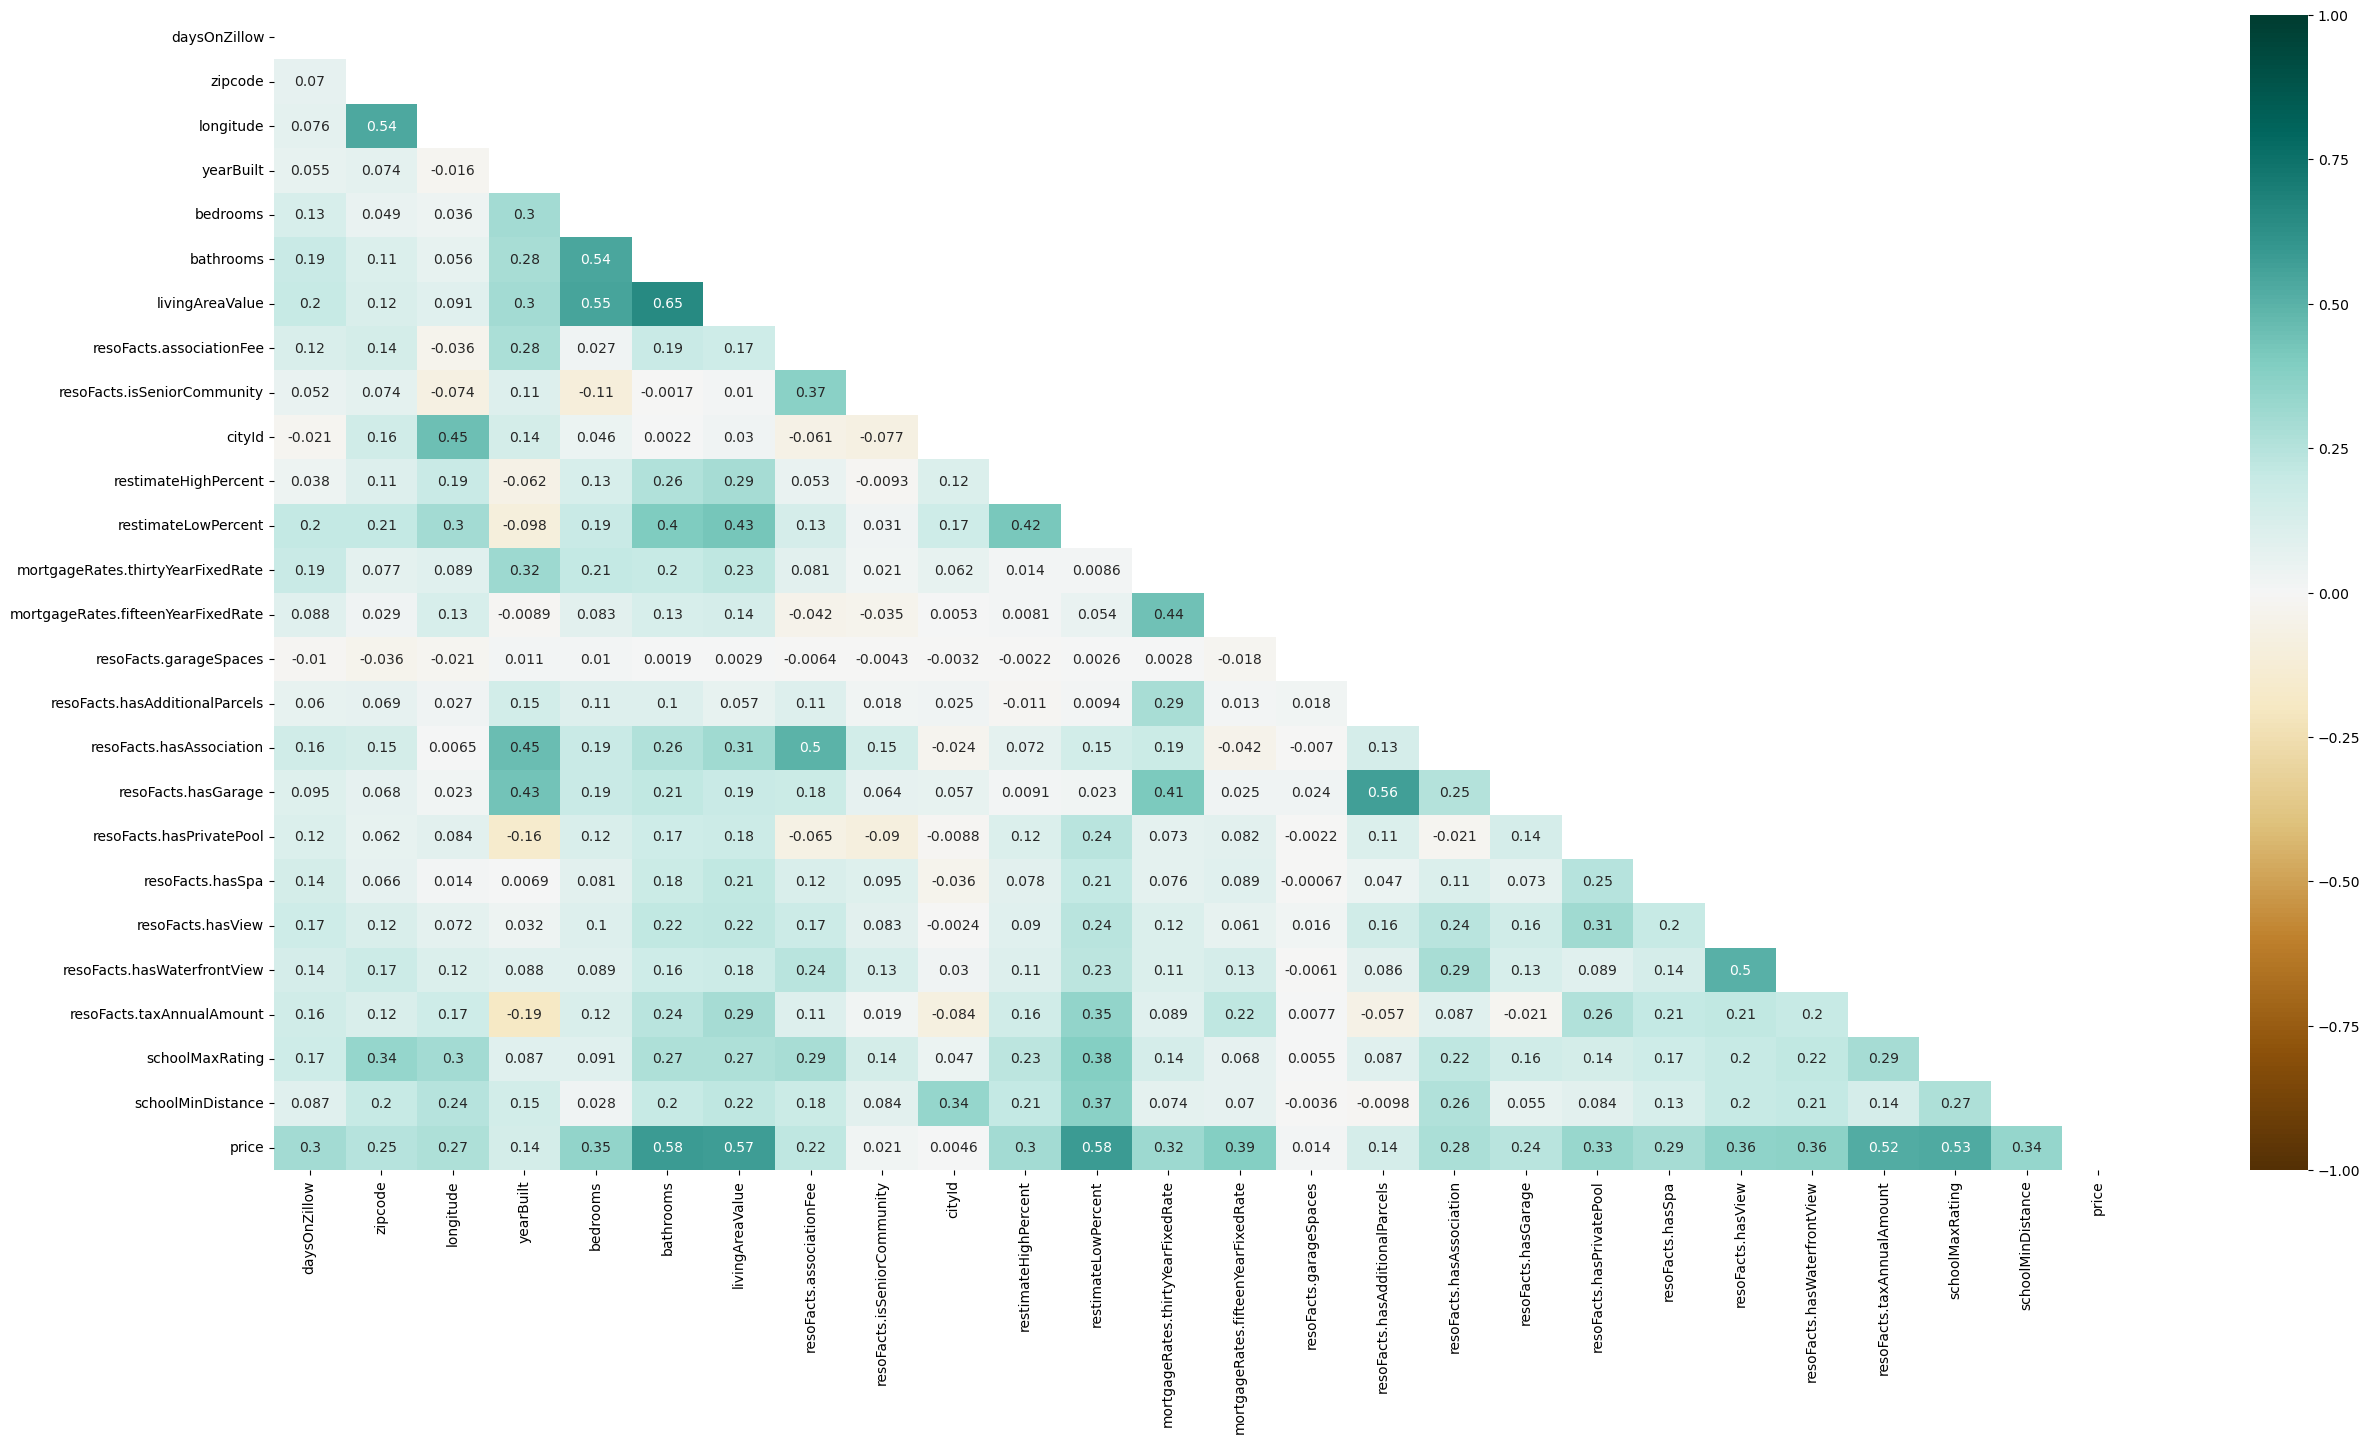

In [8]:
'''
Look at correlation heatmap
'''
plt.figure(figsize=(30, 15))
mask = np.triu(np.ones_like(modelData_recentlySold.corr(), dtype=np.bool_))
sns.heatmap(modelData_recentlySold.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
plt.show()

# Build, Train, Test, and Validate Models on recentlySold Dataset

In [9]:
'''
Creating variables for validation matrix at the end.
'''

MODEL = []
Training_R2 = []
MSE = []
RMSE = []
MAE = []
MAPE = []
MSLE = []

Testing_R2 = []
tMSE = []
tRMSE = []
tMAE = []
tMAPE = []
tMSLE = []


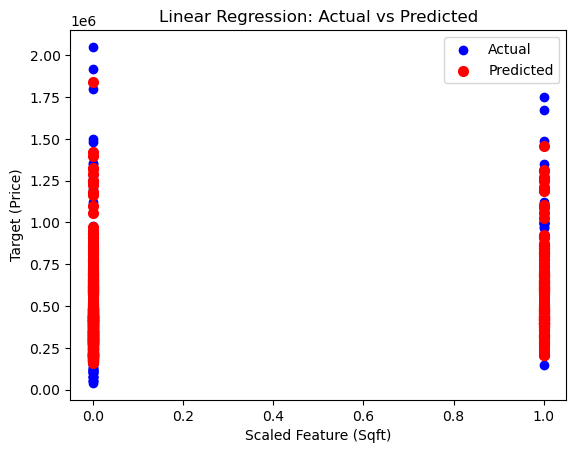

Tuned Hyperparameters :(Best Parameters)  {'fit_intercept': True}
Training R_Squared: 0.9131414231726709
Training Metrics:
MSE:  3987457286.002081
RMSE:  63146.31648799541
MAE:  37491.307767053644
MAPE:  33.47216538343457

Test Metrics:
Testing R_Squared:  0.9230972535573376
MSE:  3886096046.4567695
RMSE:  62338.55986832523
MAE:  36140.692431352494
MAPE:  9.757824115307699
MSLE:  0.023431986897754945
Adjusted R2 Score:  0.9212504056600594



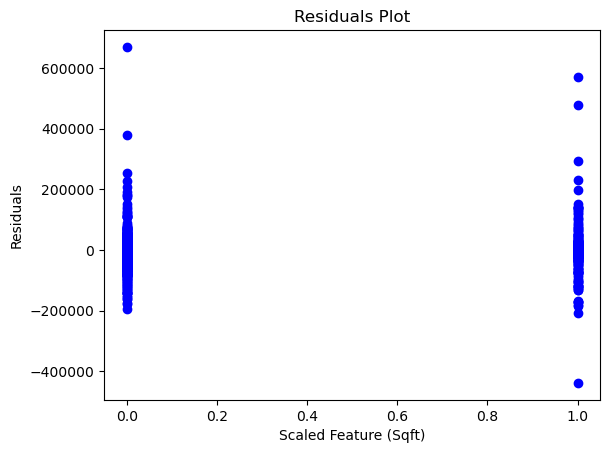

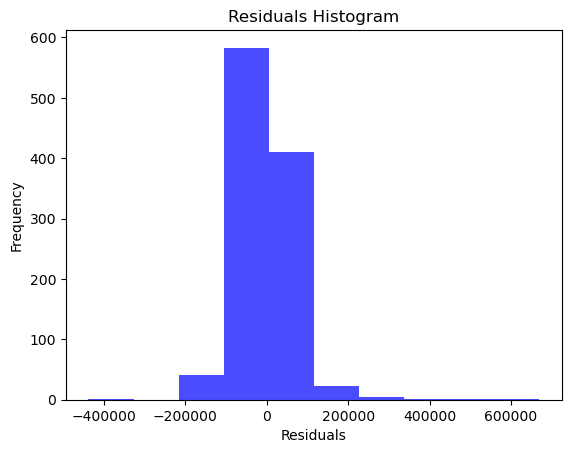

In [10]:
'''
Build, train, test, and validate a LinearRegression() model
'''
MODEL.append('Linear Regression')


# Build, train, and test the model
parameters = {'fit_intercept':[True, False]}
lr = LinearRegression()
linReg = GridSearchCV(estimator=lr, param_grid=parameters, cv=10)
linReg.fit(X_train, y_train)
y_pred = linReg.predict(X_test)

for i, value in enumerate(y_pred):
    if value < 0:
        y_pred[i] = 0

# Visualize the results
plt.scatter(X_test[:,18], y_test, color='blue', label='Actual')
plt.scatter(X_test[:,18], y_pred, color='red', linewidth=2, label='Predicted')
plt.xlabel('Scaled Feature (Sqft)')
plt.ylabel('Target (Price)')
plt.title('Linear Regression: Actual vs Predicted')
plt.legend()
plt.show()

# Validate the model
print("Tuned Hyperparameters :(Best Parameters) ",linReg.best_params_)
print("Training R_Squared:",linReg.best_score_) # this value is the best score on TRAINING data!!
Training_R2.append(linReg.best_score_)
print('Training Metrics:')

# score_lr = linReg.score(X_train, y_train) # this value is the best score on TESTING data!!
# print("Testing R_Squared: ", score_lr)
score_lr = mean_squared_error(y_train, linReg.predict(X_train))
print("MSE: ", score_lr)
MSE.append(score_lr)
score_lr = np.sqrt(score_lr)
print("RMSE: ", score_lr)
RMSE.append(score_lr)
score_lr = mean_absolute_error(y_train, linReg.predict(X_train))
print("MAE: ", score_lr)
MAE.append(score_lr)
score_lr = mean_absolute_percentage_error(y_train, linReg.predict(X_train))
print("MAPE: ", score_lr)
MAPE.append(score_lr)
# score_lr = mean_squared_log_error(y_train, linReg.predict(X_train))
# print("MSLE: ", score_lr)
MSLE.append(None)
# score_lr = r2_score(y_train, linReg.predict(X_train))
# n = len(y_train)
# k = X_train.shape[1]
# score_lr = 1 - ((1-score_lr) * (n-1) / (n-k-1))
# print("Adjusted R2 Score: ", score_lr)
print('')

print('Test Metrics:')
score_lr = linReg.score(X_test, y_test) # this value is the best score on TESTING data!!
print("Testing R_Squared: ", score_lr)
Testing_R2.append(score_lr)
score_lr = mean_squared_error(y_test, y_pred)
print("MSE: ", score_lr)
tMSE.append(score_lr)
score_lr = np.sqrt(score_lr)
print("RMSE: ", score_lr)
tRMSE.append(score_lr)
score_lr = mean_absolute_error(y_test, y_pred)
print("MAE: ", score_lr)
tMAE.append(score_lr)
score_lr = mean_absolute_percentage_error(y_test, y_pred)
print("MAPE: ", score_lr)
tMAPE.append(score_lr)
score_lr = mean_squared_log_error(y_test, y_pred)
print("MSLE: ", score_lr)
tMSLE.append(score_lr)
score_lr = r2_score(y_test, y_pred)
n = len(y_test)
k = X_test.shape[1]
score_lr = 1 - ((1-score_lr) * (n-1) / (n-k-1))
print("Adjusted R2 Score: ", score_lr)
print('')

# Plot errors
residuals = y_test - y_pred
# Scatter plot of residuals
plt.scatter(X_test[:,18], residuals, color='blue', marker='o')
plt.xlabel('Scaled Feature (Sqft)')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.show()

# Histogram of residuals
plt.hist(residuals, bins=10, color='blue', alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residuals Histogram')
plt.show()

del residuals

In [11]:
# '''
# Build, train, test, and validate a LassoRegression() model
# '''

# # Build, train, and test the model
# parameters = {'fit_intercept':[True, False], 'alpha':[0.1, 0.01]}
# la = Lasso()
# laReg = GridSearchCV(estimator=la, param_grid=parameters, cv=10)
# laReg.fit(X_train, y_train)
# y_pred = laReg.predict(X_test)

# for i, value in enumerate(y_pred):
#     if value < 0:
#         y_pred[i] = 0

# # Visualize the results
# plt.scatter(X_test[:,2], y_test, color='blue', label='Actual')
# plt.scatter(X_test[:,2], y_pred, color='red', linewidth=2, label='Predicted')
# plt.xlabel('Scaled Feature (Sqft)')
# plt.ylabel('Target (Price)')
# plt.title('Lasso Regression: Actual vs Predicted')
# plt.legend()
# plt.show()

# # Validate the model
# print("Tuned Hyperparameters :(Best Parameters) ",laReg.best_params_)
# print("Training R_Squared:",laReg.best_score_) # this value is the best score on TRAINING data!!
# print('Training Metrics:')

# # score_lr = linReg.score(X_train, y_train) # this value is the best score on TESTING data!!
# # print("Testing R_Squared: ", score_lr)
# score_lr = mean_squared_error(y_train, laReg.predict(X_train))
# print("MSE: ", score_lr)
# score_lr = np.sqrt(score_lr)
# print("RMSE: ", score_lr)
# score_lr = mean_absolute_error(y_train, laReg.predict(X_train))
# print("MAE: ", score_lr)
# score_lr = mean_absolute_percentage_error(y_train, laReg.predict(X_train))
# print("MAPE: ", score_lr)
# # score_lr = mean_squared_log_error(y_train, laReg.predict(X_train))
# # print("MSLE: ", score_lr)
# # score_lr = r2_score(y_train, laReg.predict(X_train))
# # n = len(y_train)
# # k = X_train.shape[1]
# # score_lr = 1 - ((1-score_lr) * (n-1) / (n-k-1))
# # print("Adjusted R2 Score: ", score_lr)
# print('')

# print('Test Metrics:')
# score_lr = laReg.score(X_test, y_test) # this value is the best score on TESTING data!!
# print("Testing R_Squared: ", score_lr)
# score_lr = mean_squared_error(y_test, y_pred)
# print("MSE: ", score_lr)
# score_lr = np.sqrt(score_lr)
# print("RMSE: ", score_lr)
# score_lr = mean_absolute_error(y_test, y_pred)
# print("MAE: ", score_lr)
# score_lr = mean_absolute_percentage_error(y_test, y_pred)
# print("MAPE: ", score_lr)
# score_lr = mean_squared_log_error(y_test, y_pred)
# print("MSLE: ", score_lr)
# score_lr = r2_score(y_test, y_pred)
# n = len(y_test)
# k = X_test.shape[1]
# score_lr = 1 - ((1-score_lr) * (n-1) / (n-k-1))
# print("Adjusted R2 Score: ", score_lr)
# print('')

# # Plot errors
# residuals = np.transpose(y_test) - y_pred
# # Scatter plot of residuals
# plt.scatter(X_test[:, 2], residuals, color='blue', marker='o')
# plt.xlabel('Scaled Feature (Sqft)')
# plt.ylabel('Residuals')
# plt.title('Residuals Plot')
# plt.show()

# residuals = np.transpose(residuals)
# # Histogram of residuals
# plt.hist(residuals, bins=10, color='blue', alpha=0.7)
# plt.xlabel('Residuals')
# plt.ylabel('Frequency')
# plt.title('Residuals Histogram')
# plt.show()

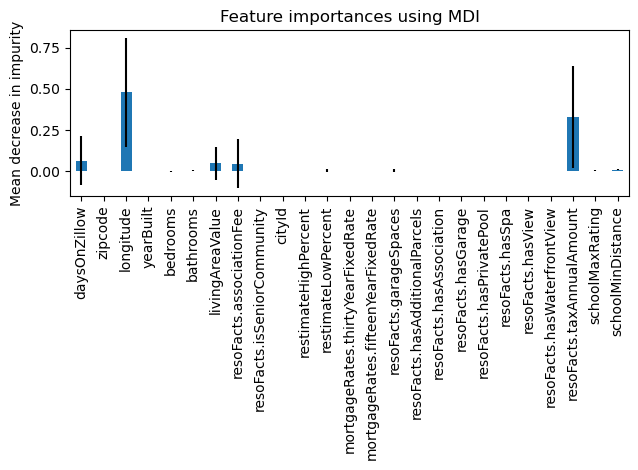

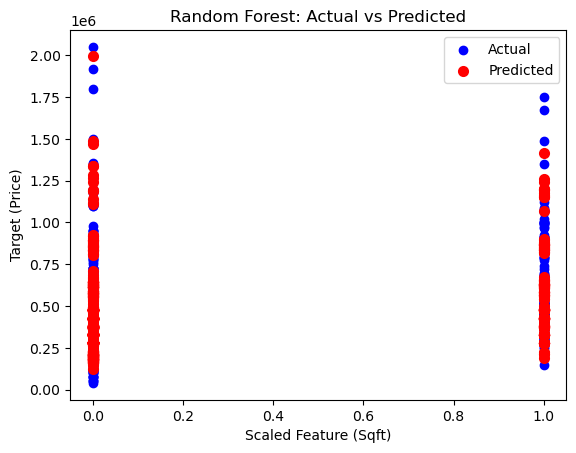

Tuned Hyperparameters: (Best Parameters)  {'max_depth': 10, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 100}
Best Estimator:  RandomForestRegressor(max_depth=10, min_samples_leaf=3, random_state=42)
Training R_Squared: 0.9542448044058769
Training Metrics:
MSE:  995205750.7627233
RMSE:  31546.88179143421
MAE:  19547.732624447683
MAPE:  21.87084233339263

Test Metrics:
Testing R_Squared:  0.9513128869408645
MSE:  2460286612.956889
RMSE:  49601.276323869824
MAE:  27625.925222137426
MAPE:  7.5873583565325005
MSLE:  0.01744021971403767
Adjusted R2 Score:  0.9501436479144684



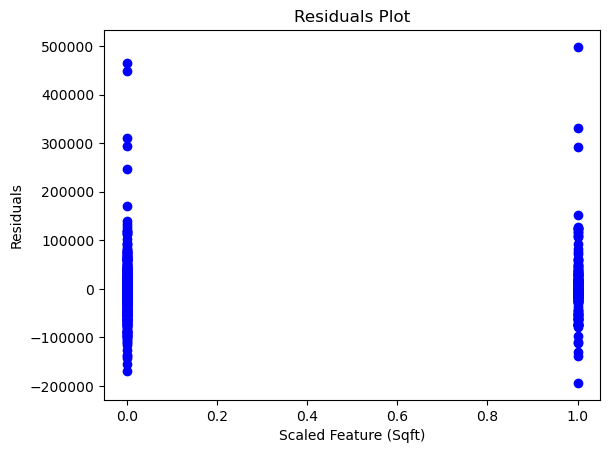

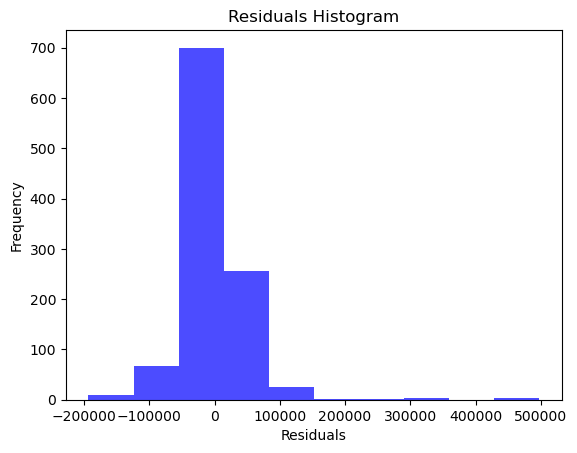

In [12]:
'''
Build, train, test, and validate a RandomForest() model
'''
MODEL.append('Random Forest')

# # Split the data: recentlySold = 80% train/20% test. forSale = 100% test
# X_temp = X_test
# y_temp = y_test
# X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=35)

# Build, train, and test the model
parameters = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 5]
}

# parameters = {
#     'n_estimators': [150],
#     'max_depth': [10],
#     'min_samples_split': [2],
#     'min_samples_leaf': [1]
# }

# randFor = RandomForestRegressor(n_estimators=150, random_state=42)

# rf = RandomForestRegressor(random_state=42)
# randFor = GridSearchCV(estimator=rf, param_grid=parameters, cv=5, scoring='r2', n_jobs=-1)
# randFor.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=False, early_stopping_rounds=10)

rf = RandomForestRegressor(random_state=42)
randFor = GridSearchCV(estimator=rf, param_grid=parameters, cv=10, scoring='r2', n_jobs=-1)
randFor.fit(X_train, y_train)

best_randFor = randFor.best_estimator_

y_pred = best_randFor.predict(X_test)

for i, value in enumerate(y_pred):
    if value < 0:
        y_pred[i] = 0

importances = best_randFor.feature_importances_
std = np.std([tree.feature_importances_ for tree in best_randFor.estimators_], axis=0)
modelData_recentlySold.drop('price', axis=1, inplace=True)
forest_importances = pd.Series(importances, index=modelData_recentlySold.columns)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
plt.show()

# Visualize the results
plt.scatter(X_test[:,18], y_test, color='blue', label='Actual')
plt.scatter(X_test[:,18], y_pred, color='red', linewidth=2, label='Predicted')
plt.xlabel('Scaled Feature (Sqft)')
plt.ylabel('Target (Price)')
plt.title('Random Forest: Actual vs Predicted')
plt.legend()
plt.show()

df_results = pd.DataFrame()

# Validate the model
print("Tuned Hyperparameters: (Best Parameters) ",randFor.best_params_)
print("Best Estimator: ",randFor.best_estimator_)
print("Training R_Squared:",randFor.best_score_) # this value is the best score on TRAINING data!!
Training_R2.append(randFor.best_score_)
print('Training Metrics:')

# score_lr = linReg.score(X_train, y_train) # this value is the best score on TESTING data!!
# print("Testing R_Squared: ", score_lr)
score_lr = mean_squared_error(y_train, randFor.predict(X_train))
print("MSE: ", score_lr)
MSE.append(score_lr)
score_lr = np.sqrt(score_lr)
print("RMSE: ", score_lr)
RMSE.append(score_lr)
score_lr = mean_absolute_error(y_train, randFor.predict(X_train))
print("MAE: ", score_lr)
MAE.append(score_lr)
score_lr = mean_absolute_percentage_error(y_train, randFor.predict(X_train))
print("MAPE: ", score_lr)
MAPE.append(score_lr)
# score_lr = mean_squared_log_error(y_train, randFor.predict(X_train))
# print("MSLE: ", score_lr)
MSLE.append(None)
# score_lr = r2_score(y_train, randFor.predict(X_train))
# n = len(y_train)
# k = X_train.shape[1]
# score_lr = 1 - ((1-score_lr) * (n-1) / (n-k-1))
# print("Adjusted R2 Score: ", score_lr)
print('')

print('Test Metrics:')
score_lr = randFor.score(X_test, y_test) # this value is the best score on TESTING data!!
print("Testing R_Squared: ", score_lr)
Testing_R2.append(score_lr)
score_lr = mean_squared_error(y_test, y_pred)
print("MSE: ", score_lr)
tMSE.append(score_lr)
score_lr = np.sqrt(score_lr)
print("RMSE: ", score_lr)
tRMSE.append(score_lr)
score_lr = mean_absolute_error(y_test, y_pred)
print("MAE: ", score_lr)
tMAE.append(score_lr)
score_lr = mean_absolute_percentage_error(y_test, y_pred)
print("MAPE: ", score_lr)
tMAPE.append(score_lr)
score_lr = mean_squared_log_error(y_test, y_pred)
print("MSLE: ", score_lr)
tMSLE.append(score_lr)
score_lr = r2_score(y_test, y_pred)
n = len(y_test)
k = X_test.shape[1]
score_lr = 1 - ((1-score_lr) * (n-1) / (n-k-1))
print("Adjusted R2 Score: ", score_lr)
print('')

# Plot errors
residuals = np.transpose(y_test) - y_pred
# Scatter plot of residuals
plt.scatter(X_test[:,18], residuals, color='blue', marker='o')
plt.xlabel('Scaled Feature (Sqft)')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.show()

residuals = np.transpose(residuals)
# Histogram of residuals
plt.hist(residuals, bins=10, color='blue', alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residuals Histogram')
plt.show()

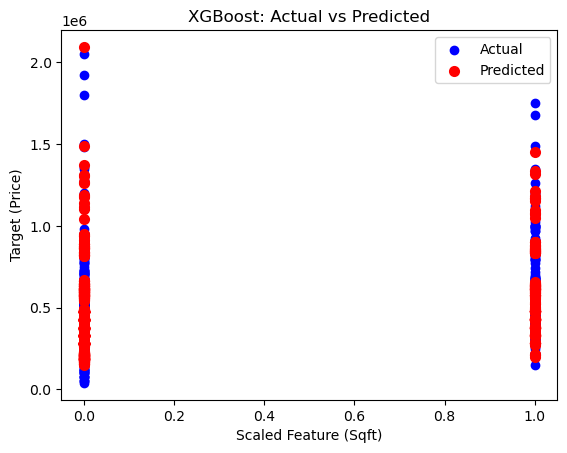

Tuned Hyperparameters: (Best Parameters)  {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 1.0}
Best Estimator:  XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)
Training R_Squared: 0.9571617836462568
Training Metrics:
MSE:  1019988

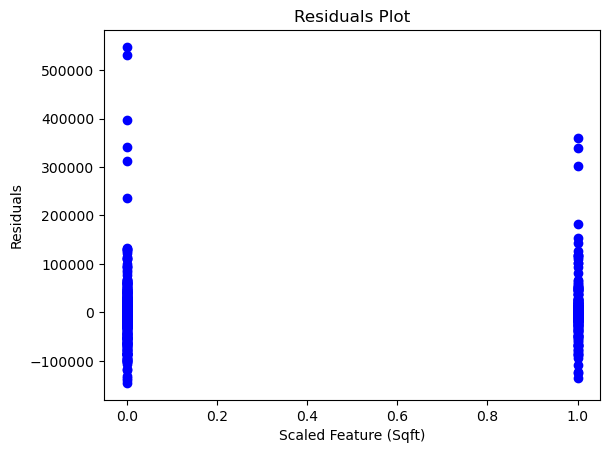

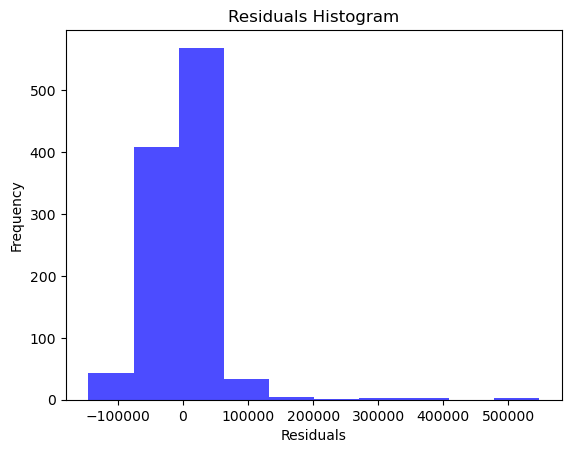

In [13]:
'''
Build, train, test, and validate a XGBoost() model
'''
MODEL.append('XGBoost')

# Split the data: recentlySold = 80% train/20% test. forSale = 100% test
# X_temp = X_test
# y_temp = y_test
# X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=35)


# Build, train, and test the model
parameters = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'min_child_weight': [1, 5, 10],
    'gamma': [0, 0.1, 0.2]
}

# best_parameters = {
#     'n_estimators': [150],
#     'max_depth': [3],
#     'learning_rate': [0.2],
#     'subsample': [1.0],
#     'colsample_bytree': [1.0],
#     'min_child_weight': [1],
#     'gamma': [0]
# }

# xg = XGBRegressor(objective='reg:squarederror', random_state=42, early_stopping_rounds=10)
xg = XGBRegressor(objective='reg:squarederror', random_state=42)

boost = GridSearchCV(estimator=xg, param_grid=parameters, cv=10, scoring='r2', n_jobs=-1)

# boost.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=False)
boost.fit(X_train, y_train)

best_xgb_model = boost.best_estimator_

y_pred_RF = y_pred
y_pred = best_xgb_model.predict(X_test)

for i, value in enumerate(y_pred):
    if value < 0:
        y_pred[i] = 0

y_pred_XGB = y_pred

# Visualize the results
plt.scatter(X_test[:,18], y_test, color='blue', label='Actual')
plt.scatter(X_test[:,18], y_pred, color='red', linewidth=2, label='Predicted')
plt.xlabel('Scaled Feature (Sqft)')
plt.ylabel('Target (Price)')
plt.title('XGBoost: Actual vs Predicted')
plt.legend()
plt.show()

# Validate the model
print("Tuned Hyperparameters: (Best Parameters) ",boost.best_params_)
print("Best Estimator: ",boost.best_estimator_)
print("Training R_Squared:",boost.best_score_) # this value is the best score on TRAINING data!!
Training_R2.append(boost.best_score_)
print('Training Metrics:')

# score_lr = linReg.score(X_train, y_train) # this value is the best score on TESTING data!!
# print("Testing R_Squared: ", score_lr)
score_lr = mean_squared_error(y_train, best_xgb_model.predict(X_train))
print("MSE: ", score_lr)
MSE.append(score_lr)
score_lr = np.sqrt(score_lr)
print("RMSE: ", score_lr)
RMSE.append(score_lr)
score_lr = mean_absolute_error(y_train, best_xgb_model.predict(X_train))
print("MAE: ", score_lr)
MAE.append(score_lr)
score_lr = mean_absolute_percentage_error(y_train, best_xgb_model.predict(X_train))
print("MAPE: ", score_lr)
MAPE.append(score_lr)
# score_lr = mean_squared_log_error(y_train, best_xgb_model.predict(X_train))
# print("MSLE: ", score_lr)
MSLE.append(None)
# score_lr = r2_score(y_train, best_xgb_model.predict(X_train))
# n = len(y_train)
# k = X_train.shape[1]
# score_lr = 1 - ((1-score_lr) * (n-1) / (n-k-1))
# print("Adjusted R2 Score: ", score_lr)
print('')

print('Test Metrics:')
score_lr = boost.score(X_test, y_test) # this value is the best score on TESTING data!!
print("Testing R_Squared: ", score_lr)
Testing_R2.append(score_lr)
score_lr = mean_squared_error(y_test, y_pred)
print("MSE: ", score_lr)
tMSE.append(score_lr)
score_lr = np.sqrt(score_lr)
print("RMSE: ", score_lr)
tRMSE.append(score_lr)
score_lr = mean_absolute_error(y_test, y_pred)
print("MAE: ", score_lr)
tMAE.append(score_lr)
score_lr = mean_absolute_percentage_error(y_test, y_pred)
print("MAPE: ", score_lr)
tMAPE.append(score_lr)
score_lr = mean_squared_log_error(y_test, y_pred)
print("MSLE: ", score_lr)
tMSLE.append(score_lr)
score_lr = r2_score(y_test, y_pred)
n = len(y_test)
k = X_test.shape[1]
score_lr = 1 - ((1-score_lr) * (n-1) / (n-k-1))
print("Adjusted R2 Score: ", score_lr)
print('')

# Plot errors
residuals = np.transpose(y_test) - y_pred
# Scatter plot of residuals
plt.scatter(X_test[:,18], residuals, color='blue', marker='o')
plt.xlabel('Scaled Feature (Sqft)')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.show()

residuals = np.transpose(residuals)
# Histogram of residuals
plt.hist(residuals, bins=10, color='blue', alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residuals Histogram')
plt.show()

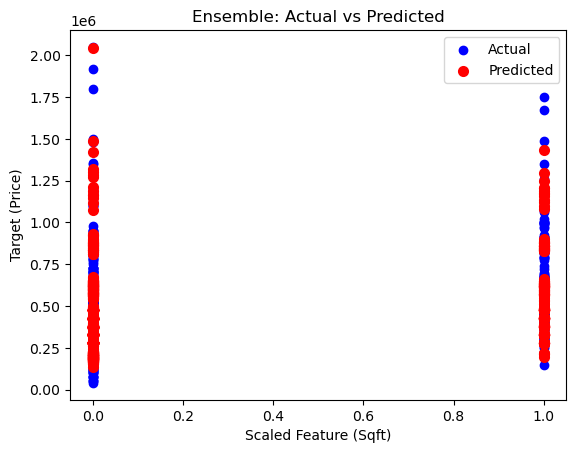

Test Metrics:
Testing R_Squared:  0.9486119720383611
MSE:  2477401417.4692416
RMSE:  49773.50115743559
MAE:  27364.61299200877
MAPE:  7.51999669866594
MSLE:  0.017188993674288864
Adjusted R2 Score:  0.9497968258348175



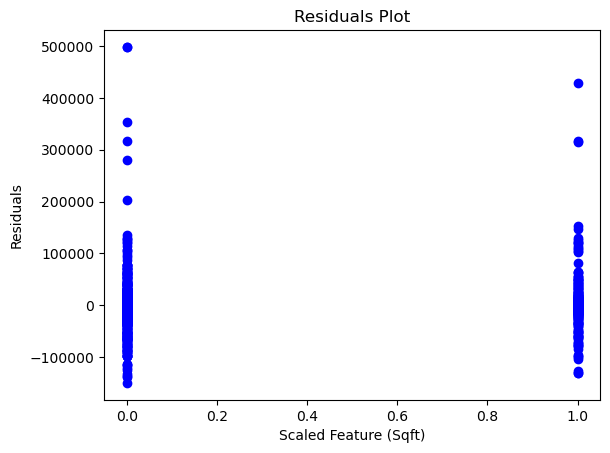

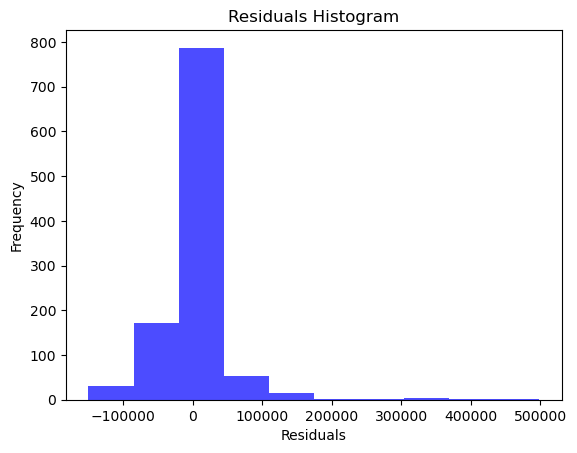

In [14]:
'''
Create Ensemble Model from RandomForest and XGBoost
'''
MODEL.append('Ensemble')

y_pred = (y_pred_RF + y_pred_XGB) / 2

# Visualize the results
plt.scatter(X_test[:,18], y_test, color='blue', label='Actual')
plt.scatter(X_test[:,18], y_pred, color='red', linewidth=2, label='Predicted')
plt.xlabel('Scaled Feature (Sqft)')
plt.ylabel('Target (Price)')
plt.title('Ensemble: Actual vs Predicted')
plt.legend()
plt.show()

Training_R2.append(None)
MSE.append(None)
RMSE.append(None)
MAE.append(None)
MAPE.append(None)
MSLE.append(None)


print('Test Metrics:')
score_lr = boost.score(X_test, y_test) # this value is the best score on TESTING data!!
print("Testing R_Squared: ", score_lr)
Testing_R2.append(score_lr)
score_lr = mean_squared_error(y_test, y_pred)
print("MSE: ", score_lr)
tMSE.append(score_lr)
score_lr = np.sqrt(score_lr)
print("RMSE: ", score_lr)
tRMSE.append(score_lr)
score_lr = mean_absolute_error(y_test, y_pred)
print("MAE: ", score_lr)
tMAE.append(score_lr)
score_lr = mean_absolute_percentage_error(y_test, y_pred)
print("MAPE: ", score_lr)
tMAPE.append(score_lr)
score_lr = mean_squared_log_error(y_test, y_pred)
print("MSLE: ", score_lr)
tMSLE.append(score_lr)
score_lr = r2_score(y_test, y_pred)
n = len(y_test)
k = X_test.shape[1]
score_lr = 1 - ((1-score_lr) * (n-1) / (n-k-1))
print("Adjusted R2 Score: ", score_lr)
print('')

# Plot errors
residuals = np.transpose(y_test) - y_pred
# Scatter plot of residuals
plt.scatter(X_test[:,18], residuals, color='blue', marker='o')
plt.xlabel('Scaled Feature (Sqft)')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.show()

residuals = np.transpose(residuals)
# Histogram of residuals
plt.hist(residuals, bins=10, color='blue', alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residuals Histogram')
plt.show()

In [15]:
performanceDict = {'Model':MODEL, 'Training R2':Training_R2, 'Testing R2':Testing_R2, 'Training MSE':MSE, 'Testing MSE':tMSE, 'Training RMSE':RMSE, 
                   'Testing RMSE':tRMSE, '*Training MAE*':MAE, '*Testing MAE*':tMAE, '*Training MAPE*':MAPE, '*Testing MAPE*':tMAPE, 'Training MSLE':MSLE, 
                   'Testing MSLE':tMSLE}

df_Performance = pd.DataFrame(performanceDict)
df_Performance.head()

,Model,Training R2,Testing R2,Training MSE,Testing MSE,Training RMSE,Testing RMSE,*Training MAE*,*Testing MAE*,*Training MAPE*,*Testing MAPE*,Training MSLE,Testing MSLE
0,Linear Regression,0.913141,0.923097,3.987457e+09,3.886096e+09,63146.316488,62338.559868,37491.307767,36140.692431,33.472165,9.757824,None,0.023432
1,Random Forest,0.954245,0.951313,9.952058e+08,2.460287e+09,31546.881791,49601.276324,19547.732624,27625.925222,21.870842,7.587358,None,0.017440
2,XGBoost,0.957162,0.948612,1.019988e+09,2.596771e+09,31937.254948,50958.521139,21585.088277,27612.494919,23.390436,7.559836,None,0.017253
3,Ensemble,NaN,0.948612,NaN,2.477401e+09,NaN,49773.501157,NaN,27364.612992,NaN,7.519997,None,0.017189


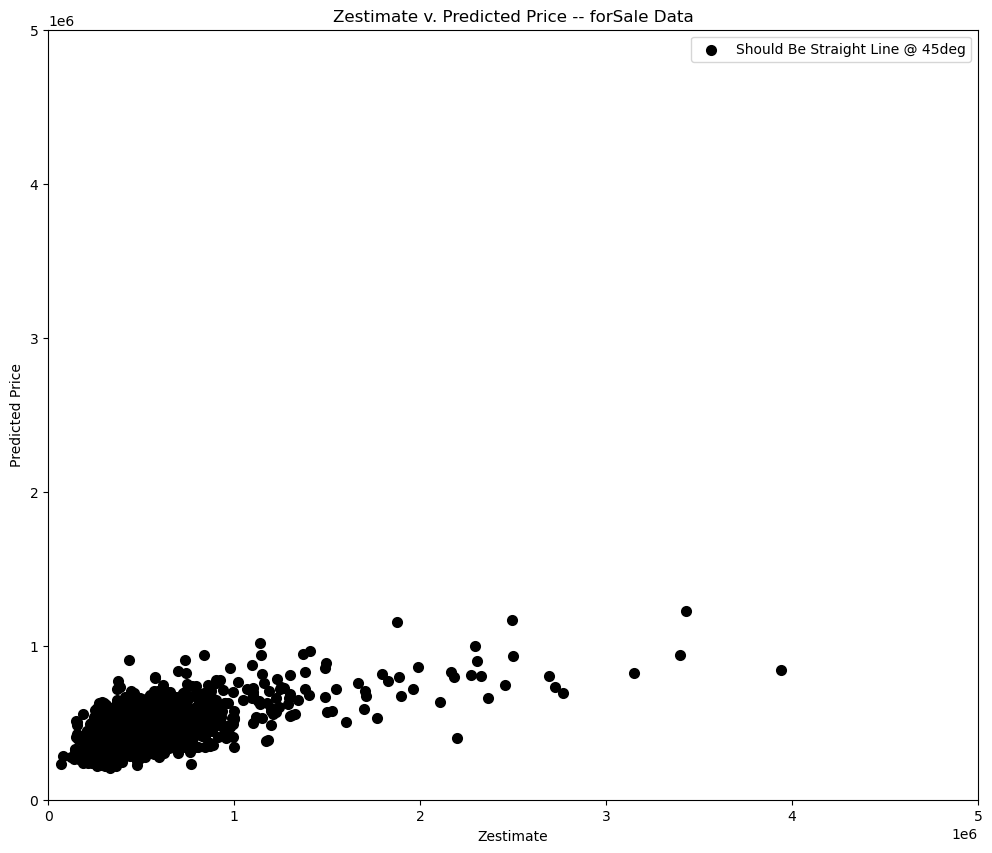

Test Metrics:
MSE:  67334099192.35447
RMSE:  259488.14846222644
MAE:  140504.601614139
MAPE:  27.344023887484738
MSLE:  0.12490897623016148
Adjusted R2 Score:  0.3164387149846696



In [21]:
'''
Execute best model on forSale Data

XXXX NEEDS WORK!!! I DO NOT BELIEVE THESE RESULTS!! XXXX
'''
# X_train = np.array([3.00000000e+00, 4.00000000e+00, 7.70000000e+01, 0.00000000e+00, 2.87146700e+01, 0.00000000e+00, 2.63500000e+03, -8.08855700e+01, 1.05415200e+05, 3.20000000e+01, 1.42314991e+02, 0.00000000e+00, 0.00000000e+00, 2.00400000e+03, 3.77600000e+05, 3.27540000e+04])
# X_forSale = X_train


# Create predicted price
# forSale_pricePrediction = best_randFor.predict(X_forSale)
# forSale_pricePrediction = best_xgb_model.predict(X_forSale)
# forSale_pricePrediction = linReg.predict(X_forSale)
forSale_pricePrediction = (best_randFor.predict(X_forSale) + best_xgb_model.predict(X_forSale)) / 2


# Visualize the results
plt.figure(figsize=(12, 10))
# plt.scatter(modelData_forSale['resoFacts.taxAnnualAmount'], zestimate, color='blue', label='Actual')
# plt.scatter(modelData_forSale['resoFacts.taxAnnualAmount'], forSale_pricePrediction, color='red', linewidth=2, label='Predicted')
plt.scatter(zestimate, forSale_pricePrediction, color='black', linewidth=2, label='Should Be Straight Line @ 45deg')
plt.xlabel('Zestimate')
plt.ylabel('Predicted Price')
plt.title('Zestimate v. Predicted Price -- forSale Data')
plt.xlim([0, 5e6])
plt.ylim([0, 5e6])
plt.legend()
plt.show()

# print(forSale_pricePrediction[0:4])
# print(zestimate[0:4])

y_pred = forSale_pricePrediction
y_test = zestimate

print('Test Metrics:')
score_lr = mean_squared_error(y_test, y_pred)
print("MSE: ", score_lr)
score_lr = np.sqrt(score_lr)
print("RMSE: ", score_lr)
score_lr = mean_absolute_error(y_test, y_pred)
print("MAE: ", score_lr)
score_lr = mean_absolute_percentage_error(y_test, y_pred)
print("MAPE: ", score_lr)
score_lr = mean_squared_log_error(y_test, y_pred)
print("MSLE: ", score_lr)
score_lr = r2_score(y_test, y_pred)
n = len(y_test)
k = X_test.shape[1]
score_lr = 1 - ((1-score_lr) * (n-1) / (n-k-1))
print("Adjusted R2 Score: ", score_lr)
print('')

# Add predicted price to forSale dataframe - make sure index values match up....

# Compute percent difference between zestimate and predicted price

# Create final forSale csv for use in second go of EDA and final Plotly viz

# Final EDA to include:
# - Price value (% diff predicted v. Zestimate) vs zipcode



In [17]:
print(forSale_pricePrediction.min())
print(forSale_pricePrediction.max())
print(zestimate.min())
print(zestimate.max())

202769.1974617227
1228076.245559163
71600.0
3942100.0
